# Opentender.eu datasets for UK

## Load and transform dataset
Datasets downloaded in json format from https://opentender.eu/all/download for EU institutions. Extract and store the archives in `data_json_opentender/data-uk-json`.

In [2]:
country_code = "uk"

In [3]:
import glob
import json
import pandas as pd
from fastlid import fastlid


cols = ['title_description', 'cpvs']
data = []
list_jsons = glob.glob(f"data_json_opentender/data-{country_code}-json/*")
print(list_jsons)
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

for file_name in list_jsons:
    with open(file_name) as f:
        doc = json.load(f)

    for element in doc:
        cpvs = element.get("cpvs", [])
        result_cpvs = []
        for cpv in cpvs:
            result = cpv.get("code", "na")
            if result and result != "na":
                result = result[:2]
                if result in all_divisions:
                    result_cpvs.append(result)
        title = element.get('title', '')
        if title:
            title = f'{title}. '
        description = element.get('description', '')

        title_description = f'{title}{description}'
        fastlid_output = fastlid(title_description)
        lang = fastlid_output[0]
        confidence = fastlid_output[1]
        #if lang == "en" and confidence > 0.4:
        if result_cpvs and title_description:
            lst = [title_description, result_cpvs]
            data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
df.tail()

['data_json_opentender/data-uk-json/data-uk-2018.json', 'data_json_opentender/data-uk-json/data-uk-2016.json', 'data_json_opentender/data-uk-json/data-uk-2020.json', 'data_json_opentender/data-uk-json/data-uk-year-unavailable.json', 'data_json_opentender/data-uk-json/data-uk-2009.json', 'data_json_opentender/data-uk-json/data-uk-2010.json', 'data_json_opentender/data-uk-json/data-uk-2012.json', 'data_json_opentender/data-uk-json/data-uk-2019.json', 'data_json_opentender/data-uk-json/data-uk-2014.json', 'data_json_opentender/data-uk-json/data-uk-2017.json', 'data_json_opentender/data-uk-json/data-uk-2015.json', 'data_json_opentender/data-uk-json/data-uk-2021.json', 'data_json_opentender/data-uk-json/data-uk-2013.json', 'data_json_opentender/data-uk-json/data-uk-2011.json', 'data_json_opentender/data-uk-json/data-uk-2022.json']


title_description      cpvs
450070  ETFE Roof (Cost consultant) replacement. ETFE ...      [79]
450071  Contract for the Provision of the PARIS Trial ...      [71]
450072  UK SBS - PS22084 - Consulting on Power Electro...  [73, 79]
450073  MEDICUS MAJOR UPGRADES TO SYSTEM. This notice ...      [72]
450074  SOFTWARE SUPPORT AND LICENCE FOR ICU MEDICU SY...      [72]

In [4]:
df.describe()

title_description    cpvs
count                                              450075  450075
unique                                             405164   25431
top     Client — Home Support 65 Plus Ext. Community B...    [85]
freq                                                 1865   41810

In [5]:
df.to_csv(f"data_json_opentender/notices_{country_code}_only_no_filters.csv")

In [6]:
import re
from unidecode import unidecode
import spacy.cli


spacy.cli.download("en_core_web_sm")
NLP = spacy.load("en_core_web_sm")
STOP_WORDS = NLP.Defaults.stop_words
CHARACTERS_TO_REPLACE = ["\\n", "\\r", "\\t", "\\W", "•", "\t", "-", "(", ")", ":", ";", "?", "!", "&", "\n", "\r", ".", ",", "'", "’", "´",
                         "‘", "’", '"', "“", "”", "'", "/", "\\", "%", "—", "#", "$", "[", "]", "|", "{", "}", "~", "`", "+", "*"]

MONTHS = [" january ", " february ", " march ", " april ", " may ", " june ", " july ", " august ", " september ", " october ", " november ", " december ",
          " jan ", " feb ", " mar ", " apr ", " jun ", " jul ", " aug ", " sep ", " oct ", " nov ", " dec "]

          
def _remove_multiple_spaces(text: str) -> str:
    return re.sub('\s+', ' ', text)


def _remove_special_characters(text: str) -> str:
    for chars in CHARACTERS_TO_REPLACE:
        text = text.replace(chars, " ")
    return text


def _remove_stop_words(text: str) -> str:
    token_list = text.split()
    removed_list = [x for x in token_list if x not in STOP_WORDS]
    return ' '.join(removed_list)


def _replace_digits(text):
    return re.sub(r'[\d-]+', 'NUMBER', text)


def _delete_one_letter_word(text):
    text_as_list = text.split()
    text_as_list = [element for element in text_as_list if len(element) > 1]
    return ' '.join(text_as_list)


def _remove_consecutive_duplicates(text):
    text_as_list = text.split()
    last_seen = None
    result = []
    for x in text_as_list:
        if x != last_seen:
            result.append(x)
        last_seen = x
    return ' '.join(result)

          
def _replace_months(text: str) -> str:
    text = " " + text + " "
    for month in MONTHS:
        text = text.replace(month, " MONTH ")
    return text


def _replace_with_lemma(text: str) -> str:
    doc = NLP(text)
    lemmatized_list = []
    for token in doc:
        lemmatized_list.append(token.lemma_)
    return " ".join(lemmatized_list)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
from json import JSONEncoder
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC


# adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(ytest,y_pred):
    # finally, compute metrics
    y_true = ytest
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    coverage_err = coverage_error(y_true, y_pred)
    label_ranking_average_precision = label_ranking_average_precision_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'coverage_error': coverage_err,
               'label_ranking_average_precision_score': label_ranking_average_precision}
    print(metrics)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [8]:
from ast import literal_eval
import glob
import json
import pandas as pd
from fastlid import fastlid


df = pd.read_csv(f'data_json_opentender/notices_{country_code}_only_no_filters.csv', converters={"cpvs": literal_eval}, index_col=0)

In [9]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]

def has_given_label(label, list_of_labels):
    if list_of_labels is None:
        return False
    list_of_labels = [i.lower() for i in list_of_labels]
    if label in list_of_labels:
        return True
    else:
        return False

for element in all_cpvs:
    df[element] = df["cpvs"].apply(lambda x: has_given_label(element, x))

df = df.drop(['cpvs'], axis = 1)
df.head(1)

title_description     71     44     50  \
0  Venue Hire for Clutha Fatal Accident Inquiry. ...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  

[1 rows x 46 columns]

In [10]:
df['title_description'] = df['title_description'].apply(lambda x: unidecode(str(x).lower()))
df['title_description'] = df['title_description'].apply(lambda x: _replace_with_lemma(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_special_characters(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_stop_words(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_multiple_spaces(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_digits(x))
df['title_description'] = df['title_description'].apply(lambda x: _delete_one_letter_word(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_consecutive_duplicates(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_months(x))
df = df.drop_duplicates(subset=['title_description'], keep='last')
df["title_description"].describe()

count                                                386268
unique                                               386268
top        venue hire clutha fatal accident inquiry hire...
freq                                                      1
Name: title_description, dtype: object

In [11]:
df.to_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv")

In [4]:
import pandas as pd
df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv", index_col=0)
df.head()

title_description     71     44     50  \
0   venue hire clutha fatal accident inquiry hire...  False  False  False   
1   rehabilitation reablement service southwark c...  False  False  False   
3   london quadrant housing trust supply bike sta...  False  False  False   
5   NUMBER healthy child programme delivery NUMBE...  False  False  False   
6   nexNUMBER NUMBER security service nexus curre...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False   True  False  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False  False  False   
5  False  False  False   True  False  False  ...  False  False  False  False   
6  False  False  False  False   True  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
3  False  False  False  False  False  False  
5  False  False  False  False  False  False  
6  False  False  False  False  False  False  

[5 rows x 46 columns]

In [5]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='c', edgecolor='k', alpha=0.65)
    if threshold:
        plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

In [6]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")

Text(0.5, 0, 'CPV division')

## Train model

In [7]:
from sklearn import metrics

X = df['title_description']
Y = df.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline.predict(X_test)


clf fit done


In [8]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.75      0.61      0.67      6512
          44       0.66      0.45      0.54      2895
          50       0.71      0.55      0.62      4083
          80       0.84      0.73      0.78      3633
          73       0.74      0.60      0.66      3932
          45       0.82      0.84      0.83     12793
          85       0.87      0.85      0.86      6808
          79       0.75      0.67      0.71      9741
          90       0.82      0.72      0.77      3431
          30       0.72      0.54      0.62      1378
          35       0.66      0.47      0.55      1087
          33       0.80      0.74      0.77      2968
          55       0.85      0.76      0.80       984
          72       0.66      0.56      0.60      5580
          48       0.67      0.65      0.66      3916
          38       0.76      0.69      0.72      2340
          09       0.85      0.70      0.77       853
          75       0.78    

## Predictions on data from other countries

In [9]:
list_of_countries = ["ie", "no", "uk", "eu"]
list_of_countries.remove(country_code)

for country in list_of_countries:
    df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country}_only_no_filters.csv", index_col=0)
    print("====================================================\n")
    print(f"Country: {country}")
    X = df['title_description']
    Y = df.drop(['title_description'], axis=1)
    y_pred = SVC_pipeline.predict(X)
    print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
    print(multi_label_metrics(Y, y_pred))
    print("====================================================\n")



Country: ie


/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.85      0.48      0.61     14326
          44       0.52      0.15      0.23      5163
          50       0.67      0.29      0.40      5009
          80       0.83      0.53      0.65      4701
          73       0.55      0.22      0.32      3487
          45       0.84      0.77      0.80     23424
          85       0.64      0.42      0.51      2068
          79       0.77      0.50      0.61     13945
          90       0.79      0.48      0.60      4534
          30       0.76      0.34      0.47      3096
          35       0.68      0.20      0.31      1804
          33       0.80      0.43      0.56      3953
          55       0.84      0.61      0.71      1419
          72       0.75      0.44      0.56     10273
          48       0.59      0.44      0.50      4918
          38       0.78      0.46      0.58      3699
          09       0.71      0.53      0.60       957
          75       0.55    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.70      0.14      0.23     20912
          44       0.52      0.04      0.08      9433
          50       0.48      0.06      0.11      7632
          80       0.53      0.05      0.09      6441
          73       0.52      0.06      0.11      6186
          45       0.68      0.06      0.11     85428
          85       0.44      0.08      0.14      4884
          79       0.60      0.18      0.28     13142
          90       0.79      0.23      0.36     11340
          30       0.84      0.15      0.25      7246
          35       0.37      0.06      0.10      2382
          33       0.64      0.18      0.28     12894
          55       0.75      0.10      0.18      1879
          72       0.65      0.15      0.24     13998
          48       0.51      0.13      0.21      8659
          38       0.62      0.20      0.31      5376
          09       0.86      0.14      0.25      1992
          75       0.10    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

              precision    recall  f1-score   support

          71       0.11      0.08      0.09       465
          44       0.28      0.01      0.02      1604
          50       0.47      0.06      0.10       848
          80       0.56      0.36      0.44       230
          73       0.40      0.35      0.37       428
          45       0.14      0.07      0.10       436
          85       0.19      0.10      0.13       249
          79       0.42      0.34      0.37      1352
          90       0.37      0.16      0.22       331
          30       0.82      0.29      0.43      2189
          35       0.14      0.03      0.04       236
          33       0.83      0.27      0.41      7918
          55       0.81      0.31      0.44        95
          72       0.42      0.37      0.40       493
          48       0.26      0.22      0.24       171
          38       0.37      0.21      0.27       279
          09       0.40      0.06      0.10       168
          75       0.29    

## Predictions on dataset since january 2023
Dataset available on S3: s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20220221-dataset_since_january_2023.csv ; 

In [17]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [18]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline.predict(X)
print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

              precision    recall  f1-score   support

          71       0.75      0.33      0.46         9
          44       0.00      0.00      0.00         1
          50       0.33      0.33      0.33         3
          80       1.00      0.67      0.80         6
          73       0.40      0.29      0.33         7
          45       0.86      0.86      0.86        14
          85       1.00      0.67      0.80         3
          79       0.86      0.73      0.79        26
          90       0.83      0.71      0.77         7
          30       1.00      1.00      1.00         2
          35       1.00      1.00      1.00         3
          33       0.00      0.00      0.00         0
          55       1.00      1.00      1.00         2
          72       0.67      0.86      0.75         7
          48       0.33      0.50      0.40         2
          38       0.50      1.00      0.67         1
          09       0.00      0.00      0.00         0
          75       0.00    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

# With Filters above/below thresholds

In [19]:
import glob
import json
import pandas as pd
from fastlid import fastlid

cols = ['title_description', 'cpvs', 'size']
data = []
list_jsons = glob.glob(f"data_json_opentender/data-{country_code}-json/*")
print(list_jsons)
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

for file_name in list_jsons:
    with open(file_name) as f:
        doc = json.load(f)

    for element in doc:
        size = element.get("size", None)
        if size:
            cpvs = element.get("cpvs", [])
            result_cpvs = []
            for cpv in cpvs:
                result = cpv.get("code", "na")
                if result and result != "na":
                    result = result[:2]
                    if result in all_divisions:
                        result_cpvs.append(result)
            title = element.get('title', '')
            if title:
                title = f'{title}. '
            description = element.get('description', '')

            title_description = f'{title}{description}'
            if result_cpvs and title_description:
                lst = [title_description, result_cpvs, size]
                data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
df.tail()

['data_json_opentender/data-uk-json/data-uk-2018.json', 'data_json_opentender/data-uk-json/data-uk-2016.json', 'data_json_opentender/data-uk-json/data-uk-2020.json', 'data_json_opentender/data-uk-json/data-uk-year-unavailable.json', 'data_json_opentender/data-uk-json/data-uk-2009.json', 'data_json_opentender/data-uk-json/data-uk-2010.json', 'data_json_opentender/data-uk-json/data-uk-2012.json', 'data_json_opentender/data-uk-json/data-uk-2019.json', 'data_json_opentender/data-uk-json/data-uk-2014.json', 'data_json_opentender/data-uk-json/data-uk-2017.json', 'data_json_opentender/data-uk-json/data-uk-2015.json', 'data_json_opentender/data-uk-json/data-uk-2021.json', 'data_json_opentender/data-uk-json/data-uk-2013.json', 'data_json_opentender/data-uk-json/data-uk-2011.json', 'data_json_opentender/data-uk-json/data-uk-2022.json']


title_description      cpvs  \
223694  ETFE Roof (Cost consultant) replacement. ETFE ...      [79]   
223695  Contract for the Provision of the PARIS Trial ...      [71]   
223696  UK SBS - PS22084 - Consulting on Power Electro...  [73, 79]   
223697  MEDICUS MAJOR UPGRADES TO SYSTEM. This notice ...      [72]   
223698  SOFTWARE SUPPORT AND LICENCE FOR ICU MEDICU SY...      [72]   

                       size  
223694  BELOW_THE_THRESHOLD  
223695  BELOW_THE_THRESHOLD  
223696  BELOW_THE_THRESHOLD  
223697  BELOW_THE_THRESHOLD  
223698  BELOW_THE_THRESHOLD

In [20]:
df = df.drop_duplicates(subset=['title_description'], keep='last')

In [21]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]

def has_given_label(label, list_of_labels):
    if list_of_labels is None:
        return False
    list_of_labels = [i.lower() for i in list_of_labels]
    if label in list_of_labels:
        return True
    else:
        return False

for element in all_cpvs:
    df[element] = df["cpvs"].apply(lambda x: has_given_label(element, x))

df = df.drop(['cpvs'], axis = 1)
df.head(1)

title_description                 size  \
0  Supply of Fresh Meat and Poultry Products. The...  ABOVE_THE_THRESHOLD   

      71     44     50     80     73     45     85     79  ...     18     03  \
0  False  False  False  False  False  False  False  False  ...  False  False   

      43     24     19     41     37     14     16     76  
0  False  False  False  False  False  False  False  False  

[1 rows x 47 columns]

In [22]:
df['title_description'] = df['title_description'].apply(lambda x: unidecode(str(x).lower()))
df['title_description'] = df['title_description'].apply(lambda x: _replace_with_lemma(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_special_characters(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_stop_words(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_multiple_spaces(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_digits(x))
df['title_description'] = df['title_description'].apply(lambda x: _delete_one_letter_word(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_consecutive_duplicates(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_months(x))
df = df.drop_duplicates(subset=['title_description'], keep='last')
df["title_description"].describe()

count                                                203529
unique                                               203529
top        supply cctv system upgrade ongoing maintenanc...
freq                                                      1
Name: title_description, dtype: object

In [23]:
df.to_csv(f"opentenders_{country_code}_preprocessed_title_description_with_size.csv")

In [24]:
df = pd.read_csv(f"opentenders_{country_code}_preprocessed_title_description_with_size.csv", index_col=0)

In [25]:
df["size"].describe()

count                  203529
unique                      2
top       BELOW_THE_THRESHOLD
freq                   163201
Name: size, dtype: object

In [26]:
df["size"].unique()

array(['ABOVE_THE_THRESHOLD', 'BELOW_THE_THRESHOLD'], dtype=object)

In [27]:
df_below_threshold = df[df["size"] == "BELOW_THE_THRESHOLD"]
df_above_threshold = df[df["size"] == "ABOVE_THE_THRESHOLD"]
df_below_threshold.head()

title_description                 size  \
4    hour customer contact service karbon home hou...  BELOW_THE_THRESHOLD   
8    public convenience cleansing carry cleaning N...  BELOW_THE_THRESHOLD   
10     lot NUMBER asbestos survey asbestos surveying   BELOW_THE_THRESHOLD   
13   retrofit exist fire training safety system pl...  BELOW_THE_THRESHOLD   
21   choice service maintenance repair management ...  BELOW_THE_THRESHOLD   

       71     44     50     80     73     45     85     79  ...     18     03  \
4   False  False  False  False  False  False  False   True  ...  False  False   
8   False  False  False  False  False   True  False  False  ...  False  False   
10  False  False  False  False  False  False  False  False  ...  False  False   
13  False  False  False  False  False  False  False  False  ...  False  False   
21  False  False  False  False  False  False  False  False  ...  False  False   

       43     24     19     41     37     14     16     76  
4   False  False  False  False  False  False  False  False  
8   False  False  False  False  False  False  False  False  
10  False  False  False  False  False  False  False  False  
13  False  False  False  False  False  False  False  False  
21  False  False  False  False  False  False  False  False  

[5 rows x 47 columns]

Text(0.5, 0, 'CPV division')

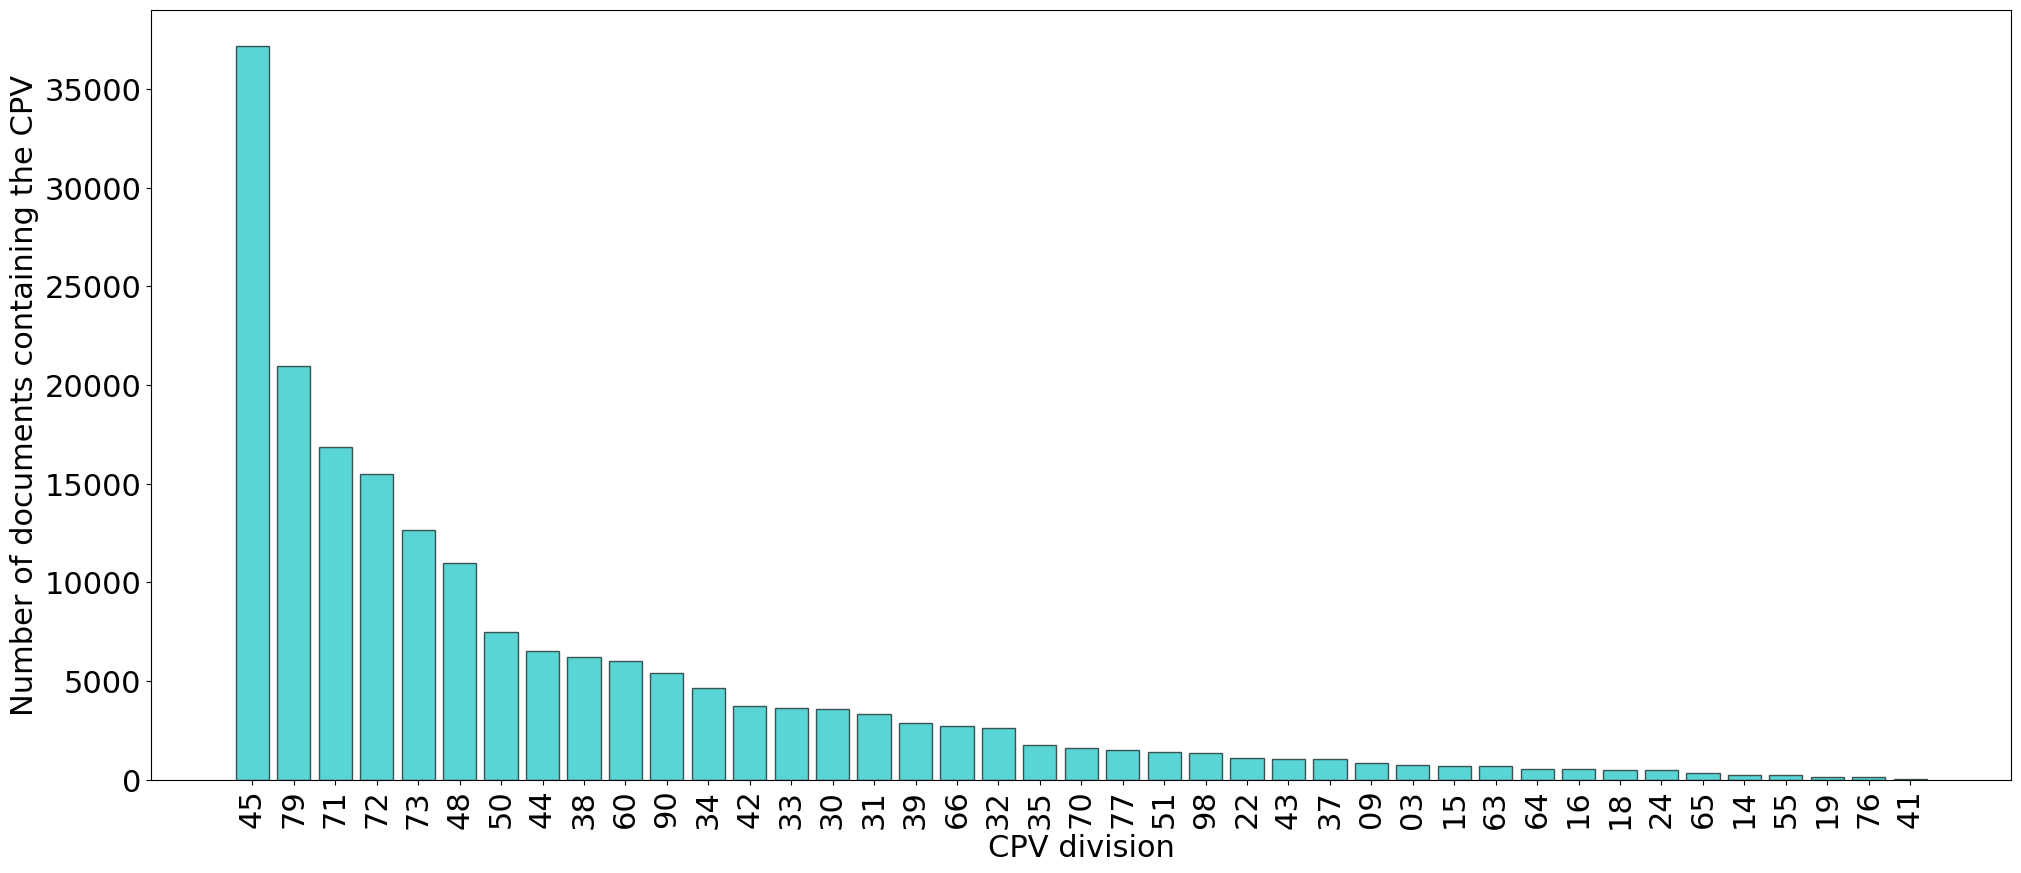

In [28]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df_below_threshold, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


Text(0.5, 0, 'CPV division')

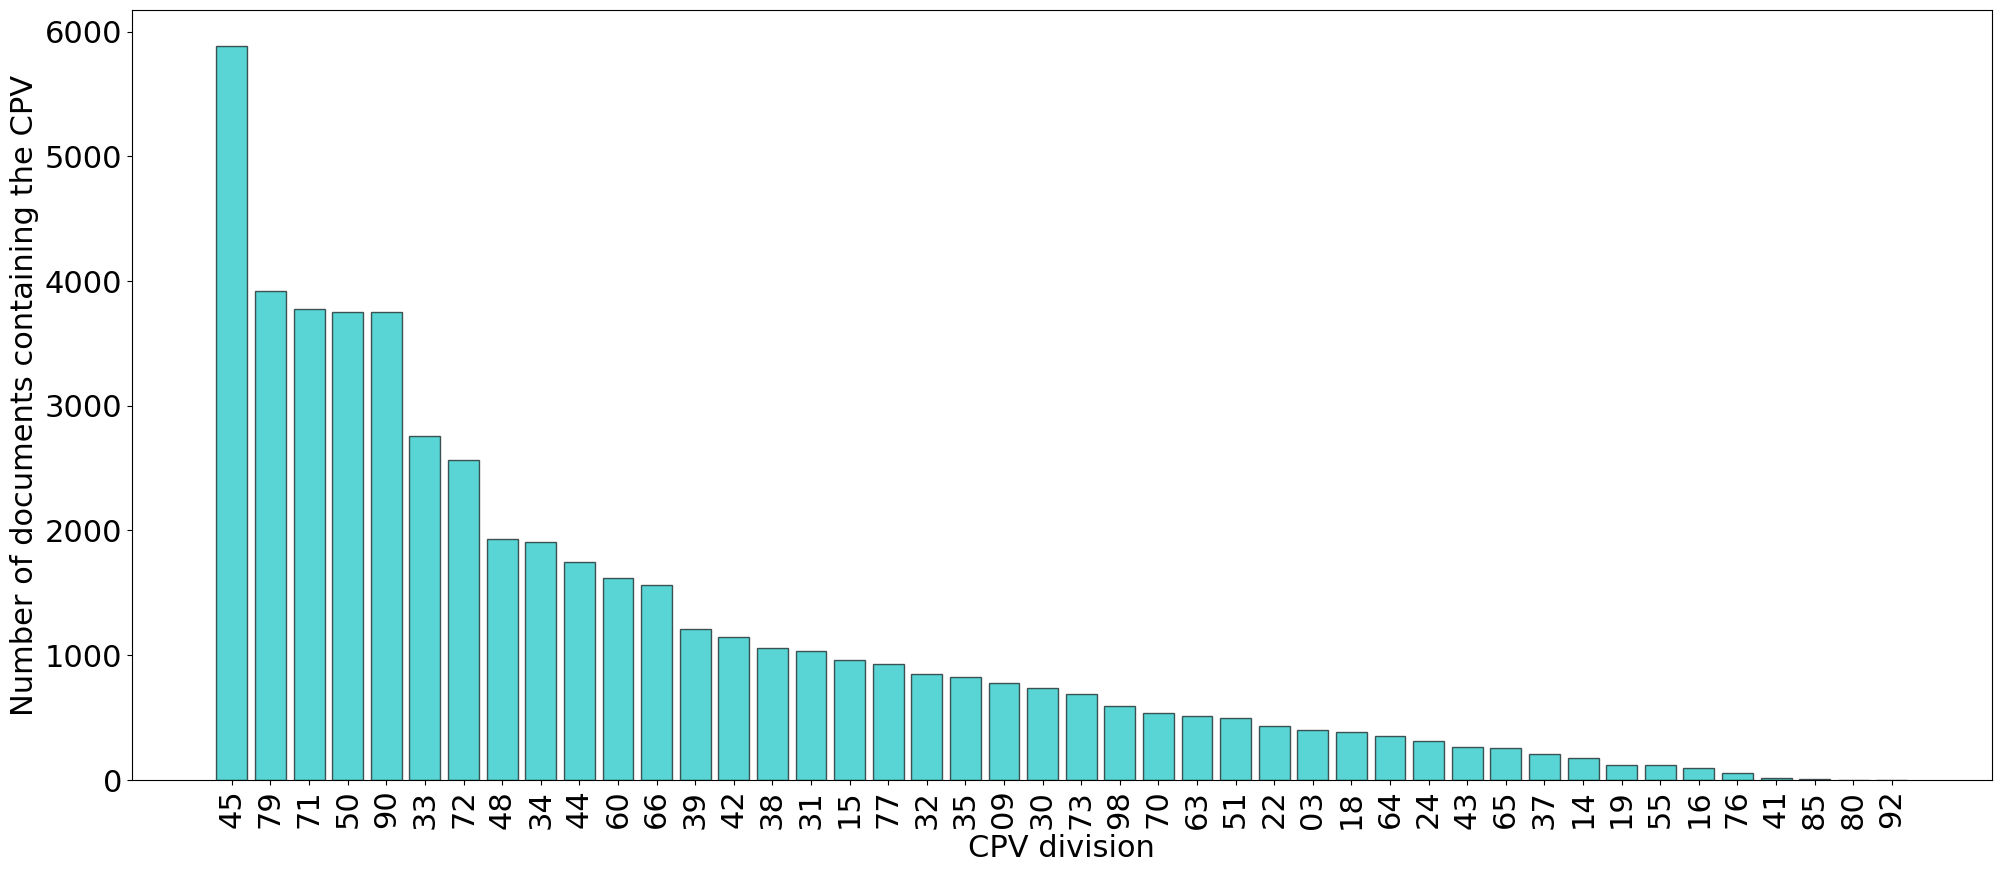

In [29]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df_above_threshold, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


In [30]:
df_below_threshold.describe()

title_description  \
count                                              163201   
unique                                             163201   
top      hour customer contact service karbon home hou...   
freq                                                    1   

                       size      71      44      50      80      73      45  \
count                163201  163201  163201  163201  163201  163201  163201   
unique                    1       2       2       2       1       2       2   
top     BELOW_THE_THRESHOLD   False   False   False   False   False   False   
freq                 163201  146327  156658  155706  163201  150535  126034   

            85      79  ...      18      03      43      24      19      41  \
count   163201  163201  ...  163201  163201  163201  163201  163201  163201   
unique       1       2  ...       2       2       2       2       2       2   
top      False   False  ...   False   False   False   False   False   False   
freq    163201  142247  ...  162684  162433  162150  162692  163055  163156   

            37      14      16      76  
count   163201  163201  163201  163201  
unique       2       2       2       2  
top      False   False   False   False  
freq    162166  162953  162662  163085  

[4 rows x 47 columns]

In [31]:
df_above_threshold.describe()

title_description  \
count                                               40328   
unique                                              40328   
top      supply cctv system upgrade ongoing maintenanc...   
freq                                                    1   

                       size     71     44     50     80     73     45     85  \
count                 40328  40328  40328  40328  40328  40328  40328  40328   
unique                    1      2      2      2      2      2      2      2   
top     ABOVE_THE_THRESHOLD  False  False  False  False  False  False  False   
freq                  40328  36553  38581  36574  40327  39639  34446  40324   

           79  ...     18     03     43     24     19     41     37     14  \
count   40328  ...  40328  40328  40328  40328  40328  40328  40328  40328   
unique      2  ...      2      2      2      2      2      2      2      2   
top     False  ...  False  False  False  False  False  False  False  False   
freq    36405  ...  39948  39933  40066  40016  40210  40312  40122  40156   

           16     76  
count   40328  40328  
unique      2      2  
top     False  False  
freq    40234  40274  

[4 rows x 47 columns]

In [32]:
df_above_threshold.head()

title_description                 size  \
2   supply cctv system upgrade ongoing maintenanc...  ABOVE_THE_THRESHOLD   
3   pe appointment screening service british coun...  ABOVE_THE_THRESHOLD   
6   tender waste collection recycling clease asso...  ABOVE_THE_THRESHOLD   
7   electoral print wakefield council seek tender...  ABOVE_THE_THRESHOLD   
9   award contract disease surveillance kit publi...  ABOVE_THE_THRESHOLD   

      71     44     50     80     73     45     85     79  ...     18     03  \
2  False  False  False  False  False  False  False  False  ...  False  False   
3  False  False  False  False  False  False  False   True  ...  False  False   
6  False  False  False  False  False  False  False  False  ...  False  False   
7  False  False  False  False  False  False  False  False  ...  False  False   
9  False  False  False  False  False  False  False  False  ...  False  False   

      43     24     19     41     37     14     16     76  
2  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  
6  False  False  False  False  False  False  False  False  
7  False  False  False  False  False  False  False  False  
9  False  False  False  False  False  False  False  False  

[5 rows x 47 columns]

In [33]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
df_above_threshold = df_above_threshold.drop(["size"], axis = 1)
df_below_threshold = df_below_threshold.drop(["size"], axis = 1)

In [34]:
from sklearn import metrics

X = df_above_threshold['title_description']
Y = df_above_threshold.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline_above = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline_above.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline_above.predict(X_test)
print("Above threshold: \n")
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(


clf fit done
Above threshold: 

              precision    recall  f1-score   support

          71       0.74      0.61      0.67       758
          44       0.79      0.47      0.59       359
          50       0.75      0.65      0.70       788
          80       0.00      0.00      0.00         1
          73       0.76      0.43      0.55       144
          45       0.78      0.75      0.77      1144
          85       0.00      0.00      0.00         2
          79       0.77      0.66      0.71       750
          90       0.89      0.81      0.85       768
          30       0.76      0.46      0.57       140
          35       0.80      0.54      0.64       169
          33       0.87      0.78      0.82       565
          55       0.50      0.27      0.35        26
          72       0.62      0.58      0.60       473
          48       0.66      0.61      0.63       347
          38       0.76      0.50      0.60       211
          09       0.82      0.73      0.77      

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

{'f1': 0.6924264138463234, 'roc_auc': 0.8095364582676722, 'accuracy': 0.5544259856186462, 'coverage_error': 16.98214728489958, 'label_ranking_average_precision_score': 0.6438372591898858}
None


In [35]:
from sklearn import metrics

X = df_below_threshold['title_description']
Y = df_below_threshold.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline_below = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline_below.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline_below.predict(X_test)
print("Below threshold: \n")
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(


clf fit done
Below threshold: 

              precision    recall  f1-score   support

          71       0.74      0.59      0.66      3472
          44       0.60      0.33      0.42      1331
          50       0.65      0.48      0.55      1470
          80       0.00      0.00      0.00         0
          73       0.72      0.63      0.67      2568
          45       0.83      0.87      0.85      7426
          85       0.00      0.00      0.00         0
          79       0.72      0.67      0.70      4168
          90       0.77      0.57      0.65      1083
          30       0.72      0.53      0.61       714
          35       0.58      0.32      0.41       341
          33       0.77      0.59      0.67       757
          55       0.54      0.27      0.36        49
          72       0.63      0.53      0.57      3068
          48       0.65      0.63      0.64      2134
          38       0.74      0.71      0.72      1236
          09       0.70      0.45      0.55      

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

{'f1': 0.6802412627796552, 'roc_auc': 0.8115015858659188, 'accuracy': 0.5526485095432125, 'coverage_error': 17.432768603903067, 'label_ranking_average_precision_score': 0.6273848605665477}
None


## Against eu institution notices from january 2023

In [36]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [37]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline_above.predict(X)
print("Above threshold: \n")

print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

Above threshold: 

              precision    recall  f1-score   support

          71       0.57      0.44      0.50         9
          44       0.00      0.00      0.00         1
          50       0.20      0.33      0.25         3
          80       0.00      0.00      0.00         6
          73       0.50      0.14      0.22         7
          45       0.93      0.93      0.93        14
          85       0.00      0.00      0.00         3
          79       0.62      0.50      0.55        26
          90       0.44      0.57      0.50         7
          30       0.50      0.50      0.50         2
          35       1.00      0.67      0.80         3
          33       0.00      0.00      0.00         0
          55       1.00      1.00      1.00         2
          72       0.45      0.71      0.56         7
          48       0.25      0.50      0.33         2
          38       0.50      1.00      0.67         1
          09       0.00      0.00      0.00         0
        

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [38]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline_below.predict(X)
print("Below threshold: \n")

print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

Below threshold: 

              precision    recall  f1-score   support

          71       0.40      0.22      0.29         9
          44       0.00      0.00      0.00         1
          50       1.00      0.33      0.50         3
          80       0.00      0.00      0.00         6
          73       0.22      0.29      0.25         7
          45       0.79      0.79      0.79        14
          85       0.00      0.00      0.00         3
          79       0.76      0.50      0.60        26
          90       1.00      0.57      0.73         7
          30       0.00      0.00      0.00         2
          35       0.60      1.00      0.75         3
          33       0.00      0.00      0.00         0
          55       1.00      1.00      1.00         2
          72       0.67      0.57      0.62         7
          48       0.50      0.50      0.50         2
          38       0.33      1.00      0.50         1
          09       0.00      0.00      0.00         0
        

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a